# Naive Bayes with Liklihood Ratios on Dishonest User Dataset
**Author:** Kalea Sebesta<br>
**Date:** 15 Oct 2018<br>

**Dataset:** UC Irvine https://archive.ics.uci.edu/ml/datasets/Dishonest+Internet+users+Dataset#

**Purpose:** The purpose of this notebook is to apply a naive bayes algorithm for a classification problem on a dishonest internet user dataset and calculate likelihood ratios to see feature relationships as they correspond to an outcome of TS (trustworthyness). In order to accomplish this, the data will need to be preprocessed prior to applying the gaussian naive bayes classifier. This will also include encoding cateogrical variables, spliting the data into training and test set and applying SMOTE (Synthetic Minority Oversampling Techneque). Training, testing, and validating results will be compared and likelihood ratios calculated to better understand the feature relationships that are occurring.

In [257]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import matplotlib as plt

## Read in Data

In [258]:
#read in data
df = pd.read_csv('Dishonest_Internet_User_Expanded.csv')
df.head()

,CT,CU,LT,TC,TS,User_Status,TA
0,CT_range_4,CU_range_1,LT_range_4,sport,untrustworthy,fair,BM
1,CT_range_4,CU_range_1,LT_range_4,sport,untrustworthy,fair,BM
2,CT_range_1,CU_range_4,LT_range_4,sport,trustworthy,fair,BM
3,CT_range_2,CU_range_1,LT_range_4,sport,trustworthy,fair,BM
4,CT_range_3,CU_range_1,LT_range_4,sport,trustworthy,fair,BM



## Data Preprocessing

In [259]:
#preprocess data
# creating a dict file
target = df['TS']
TS = {'untrustworthy': 1,'trustworthy': 0} 

# traversing through dataframe 
# TS column and writing 
# values where key matches 
target = [TS[item] for item in target] 

trustworthy      3178
untrustworthy    1652
Name: TS, dtype: int64

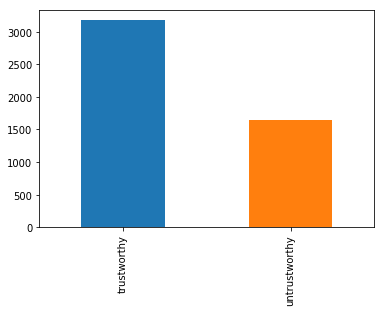

In [260]:
pd.value_counts(df['TS']).plot.bar()
df['TS'].value_counts()

### Encode Categorical Variables

In [261]:
#encode categorical variables
#label encodered used thus maps are made alphebetically
#range_1 maps to 0, range_2 maps to 1, range_3 maps to 2, range_4 maps to 3
#ECommerce maps to 0, game maps to 1, holiday maps to 2, sport maps to 3

In [262]:
features = df.drop(['TS'], axis = 1)

In [263]:
features = features.apply(preprocessing.LabelEncoder().fit_transform)

In [264]:
features.head()

,CT,CU,LT,TC,User_Status,TA
0,3,0,3,3,0,0
1,3,0,3,3,0,0
2,0,2,3,3,0,0
3,1,0,3,3,0,0
4,2,0,3,3,0,0


In [265]:
#transform features
features = StandardScaler().fit_transform(features)

### Split Data into Train/Test

In [266]:
#split data into train and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

### Apply SMOTE

In [267]:
#smote to balance dataset
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

## Create Model and Confusion Matrix

In [283]:
#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets 
model.fit(x_train_res, y_train_res)

#Predict Output 
y_pred = model.predict(X_test)

#display mislabeled output
print("Number of mislabeled points out of a total %d SMOTE points : %d"%(x_train_res.shape[0],(y_test != y_pred).sum()))

confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
tn, fp, fn, tp

#display confusion matrix
print('                  Predicted Value')
print(' Actual      |Trustworthy| Untrustworthy|')
print('Trustworthy  |  {}          {}         '.format(tn, fp))
print('Untrustworthy|  {}          {}        \n'.format(fn, tp))

print('Test Accuracy Score using SMOTE Training to predict y_test split: {}'.format(accuracy_score(y_test, y_pred)))
print('Test Sensitivity Score using SMOTE Training to predict y_test split: {}'.format(recall_score(y_test, y_pred, average = 'macro')))

Number of mislabeled points out of a total 5138 SMOTE points : 238
                  Predicted Value
 Actual      |Trustworthy| Untrustworthy|
Trustworthy  |  528          81         
Untrustworthy|  157          200        

Test Accuracy Score using SMOTE Training to predict y_test split: 0.7536231884057971
Test Sensitivity Score using SMOTE Training to predict y_test split: 0.71360958176374


## Comparing Results
Training the model using the smote train split data set to then predict the testing set results in an accuracy of 75.36% and a sensitivity of 71.35%. As a first attempt with a relatively small dataset these results aren't terrible they also aren't amazing this model is a good starting point. The confusion matrix shows that out of 5138 data points there were 238 mislabeled points. These mislabeled points were in both the false negative and false positive variables. More importantly than the accuracy of 75% is the fact that even in the unbalanced dataset the model is correctly identifying an untrustworthy user 71% of the time.

## Bayes Likelihood Ratios
**Purpose:** Likelihood will allow for relationships of impact to be seen. The BBN is harder to interpret verses the logistic regression coefficients when examining variable effects on the dependent variable. The BBN is constructed by calculating the conditional probabilities on nodes/leaves. One way to get the effects of the variable on the dependent variable is by finding the likelihood ratio for "User_status = untrustworthy". For example, let’s say A and B are two factors having an effect on "untrustworthy." Then, you could calculate the ratio of:

$$LR=\frac{Prob(untrustworthy | A=2, B=3)}{Prob(untrustworthy | A=1, B=3)}$$

And the result would be interpreted as, when B is fixed at 3 the increase in the user being untrustworthy is LR more time likely with one unit increase in A.

## Create Functions For Calculating Likeilhood Ratios

In [199]:
def likelihood_ratio(fixed_var, fixed_var_value, var, var_value):
    #likelihood ratio for CT from 0 to 1 with CU fixed at 2
    #find the number of rows where CT = 1 and CU =2
    df=data[data[var]==var_value]
    X=len(df[df[fixed_var]==fixed_var_value])

    #find the number of rows for CT being 0 and CU 2
    df=data[data[var]==var_value-1]
    Y=len(df[df[fixed_var]==fixed_var_value])
    
    #find number of rows when Tuntrustworthy is 1 for CT=1 CU=2
    df=data[data['TS']==1]
    df2=df[df[var]==var_value]
    numerator=len(df2[df2[fixed_var]==fixed_var_value])
    
    #find number of rows when TS is 1 for CT=0 CU=2
    df=data[data['TS']==1]
    df2=df[df[var]==var_value-1]
    denominator=len(df2[df2[fixed_var]==fixed_var_value])
    
    #likelihood ratio
    LR= (numerator/X)/(denominator/Y)
    return LR

In [253]:
#create function to loop through all possible combinations of variables to calculate likelihoon ratios
def display_likelihoods(var1, var2):
        for i in range(4):
            for m in range(4):
                try:
                    likelihood_ratio(var1,i ,var2, m)
                    print('Value for var1 = {}, Value for var2 = {}, Var1 = {}, Var2 = {}, Likelihood Ratio = {}'.format(i, m, var1, var2, likelihood_ratio(var1,i ,var2, m)))
                except Exception:
                    #print('Error var 1 value{}, var 2 value{}'.format(i,m))
                    continue
    

## Read in and Preprocess Data
We want to have all of the data including the target variable and encode the categorical features.

In [192]:
data = pd.read_csv('Dishonest_Internet_User_Expanded.csv')
data = data.apply(preprocessing.LabelEncoder().fit_transform)

### Apply Likihood Ratio Functions and Display Results
In order to apply the above functions, I will identify one of the variables as var1 and include all other variabes excluding the target variable in the var_list. This way I can loop through and get the likelihood ratios. The following ratios are those that were the most significant, having higher impact on the user being untrustworthy:



- Given LT is 0 (LT_range_1) it is 11.75 times more likely that the user is untrustworthy when User_Status decreases by 1 (goes from unfair to fair)
- Given User_Status is 0 (Fair) it is 10.195 times more likely that the user is untrustworthy when LT decreases by 1 (goes from LT_range_2 to LT_range_1)
- Given TA is 1 (BS) it is 9.63 times more likely that the user is untrustworthy when LT decreases by 1 (goes from LT_range_2 to LT_range_1)
- Given CT is 3 (LT_range_4) it is 7.79 times more likely that the user is untrustworthy when TC decreases by 1 (goes from Sport to holiday)
- Given TC is 3 (Sport) it is 6.12 times more likely that the user is untrustworthy when CT decreases by 1 (goes from CT_range_4 to CT_range_3)
- Given LT is 3 (LT_range_4) it is 5.69 times more likely that the user is untrustworthy when CT decreases by 1 (goes from CT_range_4 to CT_range_3)
- Given LT is 1 (LT_range_2) it is 5.3 times more likely that the user is untrustworthy when TC decreases by 1 (goes from Sport to holiday)


In [254]:
var1 = 'LT'
var_list = ['TC', 'CU', 'CT', 'TA', 'User_Status']

In [255]:
for var in var_list:
    display_likelihoods(var1,var)

Value for var1 = 0, Value for var2 = 1, Var1 = LT, Var2 = TC, Likelihood Ratio = 0.19488188976377954
Value for var1 = 0, Value for var2 = 2, Var1 = LT, Var2 = TC, Likelihood Ratio = 0.9692101740294512
Value for var1 = 1, Value for var2 = 2, Var1 = LT, Var2 = TC, Likelihood Ratio = 5.300775193798449
Value for var1 = 3, Value for var2 = 1, Var1 = LT, Var2 = TC, Likelihood Ratio = 0.12295081967213115
Value for var1 = 3, Value for var2 = 1, Var1 = LT, Var2 = CU, Likelihood Ratio = 0.360036832412523
Value for var1 = 3, Value for var2 = 2, Var1 = LT, Var2 = CU, Likelihood Ratio = 4.252371916508539
Value for var1 = 3, Value for var2 = 3, Var1 = LT, Var2 = CU, Likelihood Ratio = 1.5562248995983936
Value for var1 = 3, Value for var2 = 1, Var1 = LT, Var2 = CT, Likelihood Ratio = 0.3612750885478158
Value for var1 = 3, Value for var2 = 2, Var1 = LT, Var2 = CT, Likelihood Ratio = 0.875
Value for var1 = 3, Value for var2 = 3, Var1 = LT, Var2 = CT, Likelihood Ratio = 5.6990476190476205
Value for var1

In [284]:
var1 = 'TC'
var_list = ['LT', 'CU', 'CT', 'TA', 'User_Status']

In [285]:
for var in var_list:
    display_likelihoods(var1,var)

Value for var1 = 1, Value for var2 = 1, Var1 = TC, Var2 = LT, Likelihood Ratio = 1.0256410256410258
Value for var1 = 1, Value for var2 = 2, Var1 = TC, Var2 = LT, Likelihood Ratio = 1.011111111111111
Value for var1 = 1, Value for var2 = 3, Var1 = TC, Var2 = LT, Likelihood Ratio = 0.6428571428571429
Value for var1 = 2, Value for var2 = 1, Var1 = TC, Var2 = LT, Likelihood Ratio = 5.609405113709366
Value for var1 = 0, Value for var2 = 3, Var1 = TC, Var2 = CU, Likelihood Ratio = 1.0476878612716765
Value for var1 = 3, Value for var2 = 1, Var1 = TC, Var2 = CU, Likelihood Ratio = 0.3525224388734138
Value for var1 = 3, Value for var2 = 2, Var1 = TC, Var2 = CU, Likelihood Ratio = 1.2217194570135748
Value for var1 = 2, Value for var2 = 1, Var1 = TC, Var2 = CT, Likelihood Ratio = 5.566501175855762
Value for var1 = 3, Value for var2 = 1, Var1 = TC, Var2 = CT, Likelihood Ratio = 1.0568181818181819
Value for var1 = 3, Value for var2 = 2, Var1 = TC, Var2 = CT, Likelihood Ratio = 0.875
Value for var1 =

In [286]:
var1 = 'CU'
var_list = ['LT', 'TC', 'CT', 'TA', 'User_Status']

In [287]:
for var in var_list:
    display_likelihoods(var1,var)

Value for var1 = 0, Value for var2 = 1, Var1 = CU, Var2 = LT, Likelihood Ratio = 4.5063257775434895
Value for var1 = 0, Value for var2 = 2, Var1 = CU, Var2 = LT, Likelihood Ratio = 0.23501199040767387
Value for var1 = 0, Value for var2 = 3, Var1 = CU, Var2 = LT, Likelihood Ratio = 2.248447204968944
Value for var1 = 0, Value for var2 = 2, Var1 = CU, Var2 = TC, Likelihood Ratio = 2.4896983075791024
Value for var1 = 0, Value for var2 = 3, Var1 = CU, Var2 = TC, Likelihood Ratio = 0.954928328653761
Value for var1 = 0, Value for var2 = 1, Var1 = CU, Var2 = CT, Likelihood Ratio = 4.018496110630942
Value for var1 = 0, Value for var2 = 2, Var1 = CU, Var2 = CT, Likelihood Ratio = 0.21618625277161863
Value for var1 = 0, Value for var2 = 3, Var1 = CU, Var2 = CT, Likelihood Ratio = 2.408385093167702
Value for var1 = 0, Value for var2 = 1, Var1 = CU, Var2 = TA, Likelihood Ratio = 0.5054704595185996
Value for var1 = 0, Value for var2 = 2, Var1 = CU, Var2 = TA, Likelihood Ratio = 2.1266233766233764
Va

In [288]:
var1 = 'CT'
var_list = ['LT', 'TC', 'CU', 'TA', 'User_Status']

In [289]:
for var in var_list:
    display_likelihoods(var1,var)

Value for var1 = 3, Value for var2 = 1, Var1 = CT, Var2 = LT, Likelihood Ratio = 1.0421836228287842
Value for var1 = 3, Value for var2 = 2, Var1 = CT, Var2 = LT, Likelihood Ratio = 1.011111111111111
Value for var1 = 3, Value for var2 = 3, Var1 = CT, Var2 = LT, Likelihood Ratio = 4.662857142857143
Value for var1 = 0, Value for var2 = 3, Var1 = CT, Var2 = TC, Likelihood Ratio = 0.9394708227618702
Value for var1 = 1, Value for var2 = 3, Var1 = CT, Var2 = TC, Likelihood Ratio = 0.17836156239198064
Value for var1 = 3, Value for var2 = 2, Var1 = CT, Var2 = TC, Likelihood Ratio = 0.6655629139072848
Value for var1 = 3, Value for var2 = 3, Var1 = CT, Var2 = TC, Likelihood Ratio = 7.797101449275361
Value for var1 = 0, Value for var2 = 1, Var1 = CT, Var2 = CU, Likelihood Ratio = 0.8595505617977527
Value for var1 = 0, Value for var2 = 2, Var1 = CT, Var2 = CU, Likelihood Ratio = 4.739495798319328
Value for var1 = 0, Value for var2 = 3, Var1 = CT, Var2 = CU, Likelihood Ratio = 1.396276595744681
Valu

In [290]:
var1 = 'TA'
var_list = ['LT', 'TC', 'CU', 'CT', 'User_Status']

for var in var_list:
    display_likelihoods(var1,var)

Value for var1 = 0, Value for var2 = 1, Var1 = TA, Var2 = LT, Likelihood Ratio = 3.856115107913669
Value for var1 = 0, Value for var2 = 2, Var1 = TA, Var2 = LT, Likelihood Ratio = 0.125
Value for var1 = 0, Value for var2 = 3, Var1 = TA, Var2 = LT, Likelihood Ratio = 4.366666666666666
Value for var1 = 1, Value for var2 = 1, Var1 = TA, Var2 = LT, Likelihood Ratio = 9.6343984962406
Value for var1 = 1, Value for var2 = 2, Var1 = TA, Var2 = LT, Likelihood Ratio = 0.0
Value for var1 = 2, Value for var2 = 1, Var1 = TA, Var2 = LT, Likelihood Ratio = 2.150542495479204
Value for var1 = 2, Value for var2 = 2, Var1 = TA, Var2 = LT, Likelihood Ratio = 0.5258215962441315
Value for var1 = 2, Value for var2 = 3, Var1 = TA, Var2 = LT, Likelihood Ratio = 1.2750000000000001
Value for var1 = 3, Value for var2 = 1, Var1 = TA, Var2 = LT, Likelihood Ratio = 1.405328798185941
Value for var1 = 3, Value for var2 = 2, Var1 = TA, Var2 = LT, Likelihood Ratio = 0.7567567567567568
Value for var1 = 3, Value for var2 

In [291]:
var1 = 'User_Status'
var_list = ['LT', 'TC', 'CU', 'CT', 'TA']

for var in var_list:
    display_likelihoods(var1,var)

Value for var1 = 0, Value for var2 = 1, Var1 = User_Status, Var2 = LT, Likelihood Ratio = 10.195494376516972
Value for var1 = 0, Value for var2 = 2, Var1 = User_Status, Var2 = LT, Likelihood Ratio = 0.0
Value for var1 = 1, Value for var2 = 1, Var1 = User_Status, Var2 = LT, Likelihood Ratio = 0.22957477896926617
Value for var1 = 1, Value for var2 = 2, Var1 = User_Status, Var2 = LT, Likelihood Ratio = 4.966666666666667
Value for var1 = 1, Value for var2 = 3, Var1 = User_Status, Var2 = LT, Likelihood Ratio = 0.5432525951557093
Value for var1 = 0, Value for var2 = 1, Var1 = User_Status, Var2 = TC, Likelihood Ratio = 0.0
Value for var1 = 0, Value for var2 = 3, Var1 = User_Status, Var2 = TC, Likelihood Ratio = 0.6557555501042561
Value for var1 = 1, Value for var2 = 2, Var1 = User_Status, Var2 = TC, Likelihood Ratio = 0.6033333333333334
Value for var1 = 1, Value for var2 = 3, Var1 = User_Status, Var2 = TC, Likelihood Ratio = 1.1097766034110017
Value for var1 = 0, Value for var2 = 1, Var1 = Us